In [90]:
import pandas as pd
from pathlib import Path

In [91]:
DATA_FILE=Path(".", "data", "BC.xlsx")
df = pd.read_excel(DATA_FILE)

In [92]:
df

,client_id_phac,classification_date,classification,isoniazid_resistance,ethambutol_resistance,rifampin_resistance,pyrazinamide_resistance,amikacin_resistance,capreomycin_resistance,ethionamide_resistance,...,longterm_corticosteriod_use,injection_drug_use,solid_organ_transplant_candidate,hiv_status,alcohol_use,tobacco_use,classification_year,country_of_birth_combined,immigration_arrival_date_combine,immigration_status_combined
0,1,2018-10-16,Confirmed,R,R,R,S,R,S,R,...,Unknown,Unknown,Yes,Unknown,Yes,NaN,2018,Canada,NaT,NaN
1,2,2015-04-29,Clinical,R,S,S,S,S,S,R,...,NaN,NaN,No,Negative,Unknown,NaN,2015,Canada,NaT,NaN
2,3,2019-08-19,Confirmed,R,R,S,R,S,R,S,...,Yes,NaN,Unknown,Test refused,Yes,Unknown,2019,Canada,NaT,NaN
3,4,2020-08-09,Clinical,R,S,S,S,S,S,S,...,NaN,No,Yes,Positive,Yes,Yes,2020,Tibet,2019-04-01,Other Current Immigration Status
4,5,2020-09-19,Confirmed,S,R,S,R,S,S,S,...,Yes,Unknown,Yes,Negative,No,Unknown,2020,Ukraine,2016-09-22,Work Permit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2022-01-29,Clinical,S,S,R,R,R,S,R,...,No,Unknown,Unknown,Test not offered,Unknown,Yes,2022,Canada,NaT,NaN
996,997,2013-09-01,Confirmed,R,S,S,S,S,S,R,...,Yes,No,Unknown,Test not offered,NaN,NaN,2013,Canada,NaT,NaN
997,998,2014-02-17,Clinical,S,R,S,S,S,S,R,...,NaN,NaN,Yes,Unknown,NaN,Yes,2014,Canada,NaT,NaN
998,999,2021-03-15,Confirmed,S,S,R,S,S,R,R,...,Unknown,Yes,No,Test not offered,NaN,Unknown,2021,Tibet,2003-08-08,Foreign-born Canadian Citizen


In [93]:
# bc_1 = pd.DataFrame({
#     'RegisterCaseNumber': df['client_id_phac'],
#     'DiagnosisDate': df['classification_date'],
#     'Survey_Year': df['classification_year'],
#     'CaseCriteria': df['classification'].map({'Clinical': 2, 'Confirmed': 1}),
#     'Initial_Resistance': df.apply(lambda row: 
#                                    1 if row['classification'] == 'Confirmed' and (
#         'R' in [row['isoniazid_resistance'], row['ethambutol_resistance'], row['rifampin_resistance'], row['pyrazinamide_resistance']] or
#         all(pd.isnull([row['isoniazid_resistance'], row['ethambutol_resistance'], row['rifampin_resistance'], row['pyrazinamide_resistance']])))
#         else (2 if row['classification'] == 'Confirmed' else 9), axis=1),
#     'IR_INH': df['isoniazid_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_EMB': df['ethambutol_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_RMP': df['rifampin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_PZA': df['pyrazinamide_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_Amikacin': df['amikacin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_Capreomycin': df['capreomycin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_Ethionamide': df['ethionamide_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_Kanamycin': df['kanamycin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_Moxifloxacin': df['moxifloxacin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_Ofloxacin': df['ofloxacin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_Other': df['linezolid_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_Other_Drug': df.apply(lambda row: 'Linezolid' if pd.notna(row['linezolid_resistance']) else None, axis=1),
#     'IR_PAS': df['para_aminosalicylate_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_Rifabutin': df['rifabutin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_SM': df['streptomycin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
#     'IR_Gatifloxacin': '',
#     'IR_Levofloxacin': '',
#     'IR_Ciprofloxacin': '',
#     'IR_Clarithromycin': '',
#     'IR_Clofazamine': '',
#     'IR_Cycloserine': '',
#     'IR_Pyridoxine': '',
#     'IR_Rifapentine': '',
#     'IR_Unknown': '',
#     'Age': df['age_at_classification_date_years'],
#     'Gender': df['gender'].map({'Male': 'M', 'Female': 'F'}),
#     'Origin': df['origin'].map({'Canadian Born': 8, 'Foreign Born': 6}).fillna(9),
#     'Country_Of_Birth': df['origin'].map({
#         'Canadian Born': 'Canada',
#         'Foreign Born': df['country_of_birth_combined'].map({
#             'Taiwan': 'Taiwan (Province Of China)',
#             'Iran, Islamic Republic of': 'Iran',
#         }).fillna("Unknown")
#     }),
#     'DateOfArrival': pd.to_datetime(df['immigration_arrival_date_combine'], format='%y%m%d').dt.date,
#     'Immigration_Status': df['immigration_status_combined'].map({
#         'Foreign-born Canadian Citizen': 1,
#         'Permanent Resident': 1,
#         'Refugee Claimant': 2,
#         'Student Permit': 6,
#         'Visitor': 7,
#         'Work Permit': 5,
#         'Other Current Immigration Status': 8,
#         'Unknown': 9
#     }).fillna(9),
#     'OtherImmigStatus': df['immigration_status_combined'].apply(lambda x: 'Not Specified' if x == 'Other Current Immigration Status' else ''),
#     'CaseFinding': df['method_of_detection'].map({
#         'Symptoms compatible with site of disease': 1,
#         'Incidental finding': 2,
#         'Post-mortem': 3,
#         'Contact investigation': 4,
#         'Immigration medical surveillance': 5,
#         'Other Screening': 8,
#         'Other': 9,
#         'Unknown': 10
#     }).fillna(10),
#     'CaseFindingOther': df['method_of_detection'].apply(lambda x: 'Not specified' if x == 'Other' else ''),
#     'Case_Comment': df['tb_body_site_category_phac'],
#     'PrevAbnormalChestXRay': df['previous_abnormal_chest_xray'].map({'Yes': 1, 'No': 2}).fillna(9),
#     'TBContact2Years': df['tb_contact_within_2_years'].map({'Yes': 1, 'No': 2}).fillna(9),
#     'Diabetes': df['diabetes_mellitus'].map({'Yes': 1, 'No': 2}).fillna(9),
#     'ChronicRenalFailure': df['kidney_disease_requiring_dialysi'].map({'Yes': 1, 'No': 2}).fillna(9),
#     'Homeless': df['homelessness'].map({'Yes': 1, 'No': 2}).fillna(9),
#     'LTCorticosteroidUse': df['longterm_corticosteriod_use'].map({'Yes': 1, 'No': 2}).fillna(9),
#     'KnownSuspSubstanceAbuse': df['injection_drug_use'].map({'Yes': 1, 'No': 2}).fillna(9),
#     'Transplant': df['solid_organ_transplant_candidate'].map({'Yes': 1, 'No': 2}).fillna(9),
#     'HIVStatus': df['hiv_status'].fillna('Unknown'),
#     'Date_Of_HIV_Test': df['hiv_status'].map(lambda x: '9999/99/99' if x in ['Positive', 'Negative'] else ''),
#     'LiveCorrectionSetting': '',
#     'TravelTBCountry': '',
#     'Howlong': '',
#     'OtherRiskFactors': df.apply(
#         lambda row: 'alcohol and tobacco use' if row['alcohol_use'] == 'Yes' and row['tobacco_use'] == 'Yes'
#         else ('alcohol use' if row['alcohol_use'] == 'Yes'
#               else ('tobacco use' if row['tobacco_use'] == 'Yes' else '')), axis=1),
#     'rownumber': range(1, len(df) + 1)
# })

# bc_1.to_csv('bc_1.csv', index=False)


In [94]:
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

In [95]:
SQL_QUERY = "SELECT \
    client_id_phac AS RegisterCaseNumber, \
    classification_date AS DiagnosisDate, \
    classification_year AS Survey_Year, \
    CASE \
        WHEN lower(classification) = 'clinical' THEN 2 \
        WHEN lower(classification) = 'confirmed' THEN 1 \
    END AS CaseCriteria, \
    CASE \
        WHEN classification = 'Confirmed' AND \
            (isoniazid_resistance LIKE 'R' \
            OR ethambutol_resistance LIKE 'R' \
            OR rifampin_resistance LIKE 'R' \
            OR pyrazinamide_resistance LIKE 'R') THEN 1 \
        WHEN classification = 'Confirmed' AND \
            (isoniazid_resistance LIKE 'S' \
            OR ethambutol_resistance LIKE 'S' \
            OR rifampin_resistance LIKE 'S' \
            OR pyrazinamide_resistance LIKE 'S') THEN 2 \
        WHEN classification = 'Confirmed' AND \
            (isoniazid_resistance IS NULL \
            AND ethambutol_resistance IS NULL \
            AND rifampin_resistance IS NULL \
            AND pyrazinamide_resistance IS NULL) THEN 9 \
    END AS Initial_Resistance, \
    CASE \
        WHEN isoniazid_resistance LIKE 'R' THEN 'Resistant' \
        WHEN isoniazid_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_INH, \
    CASE \
        WHEN ethambutol_resistance LIKE 'R' THEN 'Resistant' \
        WHEN ethambutol_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_EMB, \
    CASE \
        WHEN rifampin_resistance LIKE 'R' THEN 'Resistant' \
        WHEN rifampin_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_RMP, \
    CASE \
        WHEN pyrazinamide_resistance LIKE 'R' THEN 'Resistant' \
        WHEN pyrazinamide_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_PZA, \
    CASE \
        WHEN amikacin_resistance LIKE 'R' THEN 'Resistant' \
        WHEN amikacin_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_Amikacin, \
    CASE \
        WHEN capreomycin_resistance LIKE 'R' THEN 'Resistant' \
        WHEN capreomycin_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_Capreomycin, \
    CASE \
        WHEN ethionamide_resistance LIKE 'R' THEN 'Resistant' \
        WHEN ethionamide_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_Ethionamide, \
    CASE \
        WHEN kanamycin_resistance LIKE 'R' THEN 'Resistant' \
        WHEN kanamycin_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_Kanamycin, \
    CASE \
        WHEN moxifloxacin_resistance LIKE 'R' THEN 'Resistant' \
        WHEN moxifloxacin_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_Moxifloxacin, \
    CASE \
        WHEN ofloxacin_resistance LIKE 'R' THEN 'Resistant' \
        WHEN ofloxacin_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_Ofloxacin, \
    CASE \
        WHEN linezolid_resistance LIKE 'R' THEN 'Resistant' \
        WHEN linezolid_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_Other, \
    CASE \
        WHEN linezolid_resistance IS NOT NULL THEN 'Linezolid' \
    END AS IR_Other_Drug, \
    CASE \
        WHEN para_aminosalicylate_resistance LIKE 'R' THEN 'Resistant' \
        WHEN para_aminosalicylate_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_PAS, \
    CASE \
        WHEN rifabutin_resistance LIKE 'R' THEN 'Resistant' \
        WHEN rifabutin_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_Rifabutin, \
    CASE \
        WHEN streptomycin_resistance LIKE 'R' THEN 'Resistant' \
        WHEN streptomycin_resistance LIKE 'S' THEN 'Susceptible' \
        ELSE 'Not Done' \
    END AS IR_SM, \
    '' AS IR_Gatifloxacin, \
    '' AS IR_Levofloxacin , \
    '' AS IR_Ciprofloxacin , \
    '' AS IR_Clarithromycin, \
    '' AS IR_Clofazamine , \
    '' AS IR_Cycloserine , \
    '' AS IR_Pyridoxine , \
    '' AS IR_Rifapentine , \
    '' AS IR_Unknown , \
    age_at_classification_date_years AS Age, \
    CASE \
        WHEN gender LIKE 'Male' THEN 'M' \
        WHEN gender LIKE 'Female' THEN 'F' \
    END AS Gender, \
    CASE \
        WHEN origin = 'Canadian Born' THEN 8 \
        WHEN origin = 'Foreign Born' THEN 6 \
        ELSE 9 \
    END AS Origin, \
    CASE \
        WHEN origin = 'Canadian Born' THEN 'Canada' \
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined LIKE 'Taiwan') THEN 'Taiwan (Province Of China)' \
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined LIKE 'Iran, Islamic Republic of') THEN 'Iran' \
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined Like '%Korea%') THEN 'Rep. Korea (South Korea)' \
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined LIKE 'Macao') THEN 'China, Macao SAR' \
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined LIKE 'Syrian Arab Republic') THEN 'Syrian Arab Republic (Syria)' \
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined LIKE 'Hong Kong') THEN 'China, Hong Kong SAR' \
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined LIKE 'Tibet') THEN 'Tibet (China)' \
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined IS NULL) THEN 'Unknown' \
        ELSE country_of_birth_combined \
    END AS Country_Of_Birth, \
    immigration_arrival_date_combine AS DateOfArrival, \
    CASE \
        WHEN origin = 'Foreign Born' AND immigration_status_combined IS NULL THEN 9 \
        WHEN immigration_status_combined = 'Foreign-born Canadian Citizen' THEN 1 \
        WHEN immigration_status_combined = 'Permanent Resident' THEN 1 \
        WHEN immigration_status_combined = 'Refugee Claimant' THEN 2 \
        WHEN immigration_status_combined = 'Student Permit' THEN 6 \
        WHEN immigration_status_combined = 'Visitor' THEN 7 \
        WHEN immigration_status_combined = 'Work Permit' THEN 5 \
        WHEN immigration_status_combined = 'Other Current Immigration Status' THEN 8 \
        WHEN immigration_status_combined = 'Unknown' THEN 9 \
    END AS Immigration_Status, \
    CASE \
        WHEN immigration_status_combined = 'Other Current Immigration Status' THEN 'Not Specified' \
        ELSE '' \
    END AS OtherImmigStatus, \
    CASE \
        WHEN method_of_detection = 'Symptoms compatible with site of disease' THEN 1 \
        WHEN method_of_detection = 'Incidental finding' THEN 2 \
        WHEN method_of_detection = 'Post-mortem' THEN 3 \
        WHEN method_of_detection = 'Contact investigation' THEN 4 \
        WHEN method_of_detection = 'Immigration medical surveillance' THEN 5 \
        WHEN method_of_detection = 'Other Screening' THEN 8 \
        WHEN method_of_detection = 'Other' THEN 9 \
        WHEN method_of_detection = 'Unknown' THEN 10 \
        WHEN origin = 'Foreign Born' AND method_of_detection IS NULL THEN 10 \
    END AS CaseFinding, \
    CASE \
        WHEN method_of_detection = 'Other' THEN 'Not specified' \
        ELSE '' \
    END AS CaseFindingOther, \
    tb_body_site_category_phac AS Case_Comment, \
    CASE \
        WHEN previous_abnormal_chest_xray LIKE 'Yes' THEN 1 \
        WHEN previous_abnormal_chest_xray LIKE 'No' THEN 2 \
        ELSE 9 \
    END AS PrevAbnormalChestXRay, \
    CASE \
        WHEN tb_contact_within_2_years LIKE 'Yes' THEN 1 \
        WHEN tb_contact_within_2_years LIKE 'No' THEN 2 \
        ELSE 9 \
    END AS TBContact2Years, \
    CASE \
        WHEN diabetes_mellitus like '%Yes%' THEN 1 \
        WHEN diabetes_mellitus like '%No%' THEN 2 \
        ELSE 9 \
    END AS Diabetes, \
    CASE \
        WHEN kidney_disease_requiring_dialysi like '%Yes%' THEN 1 \
        WHEN kidney_disease_requiring_dialysi like '%No%' THEN 2 \
        ELSE 9 \
    END AS ChronicRenalFailure, \
    CASE \
        WHEN homelessness like '%Yes%' THEN 1 \
        WHEN homelessness like '%No%' THEN 2 \
        ELSE 9 \
    END AS Homeless, \
    CASE \
        WHEN longterm_corticosteriod_use like '%Yes%' THEN 1 \
        WHEN longterm_corticosteriod_use like '%No%' THEN 2 \
        ELSE 9 \
    END AS LTCorticosteroidUse, \
    CASE \
        WHEN injection_drug_use like '%Yes%' THEN 1 \
        WHEN injection_drug_use like '%No%' THEN 2 \
        ELSE 9 \
    END AS KnownSuspSubstanceAbuse, \
    CASE \
        WHEN solid_organ_transplant_candidate like '%Yes%' THEN 1 \
        WHEN solid_organ_transplant_candidate like '%No%' THEN 2 \
        ELSE 9 \
    END AS Transplant, \
    CASE \
        WHEN hiv_status IS NULL THEN 'Unknown' \
        ELSE hiv_status \
    END AS HIVStatus, \
    CASE \
        WHEN hiv_status LIKE 'Positive' OR hiv_status LIKE 'Negative' THEN '9999/99/99' \
    END AS Date_Of_HIV_Test, \
    '' AS LiveCorrectionSetting, \
    '' AS TravelTBCountry, \
    '' AS Howlong, \
    CASE \
        WHEN alcohol_use LIKE 'Yes' AND tobacco_use LIKE 'Yes' THEN 'alcohol and tobacco use' \
        WHEN alcohol_use LIKE 'Yes' THEN 'alcohol use' \
        WHEN tobacco_use LIKE 'Yes' THEN 'tobacco use' \
    END AS OtherRiskFactors, \
    ROW_NUMBER() OVER (ORDER BY client_id_phac) AS rownumber \
FROM df \
"

In [96]:
result = pysqldf(SQL_QUERY)

In [97]:
SQL_QUERY = "SELECT \
    *, \
    CASE \
        WHEN AGE >= -1 AND AGE < 1 THEN 1 \
        WHEN AGE >= 1 AND AGE < 5 THEN 2 \
        WHEN AGE >= 5 AND AGE < 15 THEN 3 \
        WHEN AGE >= 15 AND AGE < 25 THEN 4 \
        WHEN AGE >= 25 AND AGE < 35 THEN 5 \
        WHEN AGE >= 35 AND AGE < 45 THEN 6 \
        WHEN AGE >= 45 AND AGE < 55 THEN 7 \
        WHEN AGE >= 55 AND AGE < 65 THEN 8 \
        WHEN AGE >= 65 AND AGE < 75 THEN 9 \
        WHEN AGE >= 75 AND AGE < 120 THEN 10 \
        ELSE 99 \
    END AS AgeGroup, \
    CASE \
        WHEN survey_year IS NOT NULL THEN survey_year || '-' || RegisterCaseNumber \
    END AS Subject_Code \
FROM result; \
"

In [98]:
result = pysqldf(SQL_QUERY)

In [99]:
result

,RegisterCaseNumber,DiagnosisDate,Survey_Year,CaseCriteria,Initial_Resistance,IR_INH,IR_EMB,IR_RMP,IR_PZA,IR_Amikacin,...,Transplant,HIVStatus,Date_Of_HIV_Test,LiveCorrectionSetting,TravelTBCountry,Howlong,OtherRiskFactors,rownumber,AgeGroup,Subject_Code
0,1,2018-10-16 00:00:00.000000,2018,1,1.0,Resistant,Resistant,Resistant,Susceptible,Resistant,...,1,Unknown,None,,,,alcohol use,1,8,2018-1
1,2,2015-04-29 00:00:00.000000,2015,2,NaN,Resistant,Susceptible,Susceptible,Susceptible,Susceptible,...,2,Negative,9999/99/99,,,,None,2,5,2015-2
2,3,2019-08-19 00:00:00.000000,2019,1,1.0,Resistant,Resistant,Susceptible,Resistant,Susceptible,...,2,Test refused,None,,,,alcohol use,3,10,2019-3
3,4,2020-08-09 00:00:00.000000,2020,2,NaN,Resistant,Susceptible,Susceptible,Susceptible,Susceptible,...,1,Positive,9999/99/99,,,,alcohol and tobacco use,4,9,2020-4
4,5,2020-09-19 00:00:00.000000,2020,1,1.0,Susceptible,Resistant,Susceptible,Resistant,Susceptible,...,1,Negative,9999/99/99,,,,None,5,8,2020-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2022-01-29 00:00:00.000000,2022,2,NaN,Susceptible,Susceptible,Resistant,Resistant,Resistant,...,2,Test not offered,None,,,,tobacco use,996,8,2022-996
996,997,2013-09-01 00:00:00.000000,2013,1,1.0,Resistant,Susceptible,Susceptible,Susceptible,Susceptible,...,2,Test not offered,None,,,,None,997,7,2013-997
997,998,2014-02-17 00:00:00.000000,2014,2,NaN,Susceptible,Resistant,Susceptible,Susceptible,Susceptible,...,1,Unknown,None,,,,tobacco use,998,4,2014-998
998,999,2021-03-15 00:00:00.000000,2021,1,1.0,Susceptible,Susceptible,Resistant,Susceptible,Susceptible,...,2,Test not offered,None,,,,None,999,4,2021-999


In [100]:
SQL_QUERY = "SELECT \
    RegisterCaseNumber, \
    Subject_Code, \
    'British Columbia' AS ReportingProvince, \
    '9999/99/99' AS Date_Of_Birth, \
    Gender, \
    Age, \
    AgeGroup, \
    '' AS City, \
    '' AS Health_Unit, \
    'Z9Z' AS PostalCode, \
    Origin, \
    '' AS Place_Lived, \
    '' AS Other_Aboriginal, \
    '' AS COBMother, \
    '' AS COBFather, \
    Country_Of_Birth, \
    DateOfArrival, \
    Immigration_Status, \
    OtherImmigStatus, \
    'Active' AS Subject_Status, \
    Survey_Year, \
    DiagnosisDate, \
    '' AS ICDOption, \
    '' AS ICD9, \
    '' AS ICD10, \
    '' AS Diagnostics_Site, \
    '' AS ChestXRay, \
    '' AS IfAbnormal, \
    '' AS M_Sputum, \
    '' AS M_BronchialWash, \
    '' AS M_GIWash, \
    '' AS M_NodeBiopsy, \
    '' AS M_Urine, \
    '' AS M_CSF, \
    '' AS M_Other, \
    '' AS C_Sputum, \
    '' AS C_BronchialWash, \
    '' AS C_GIWash, \
    '' AS C_NodeBiopsy, \
    '' AS C_Urine, \
    '' AS C_CSF, \
    '' AS C_Other, \
    '' AS BS_Microscopy, \
    '' AS BS_Culture, \
    CaseCriteria, \
    Initial_Resistance, \
    IR_INH, \
    IR_EMB, \
    IR_RMP, \
    IR_PZA, \
    IR_Amikacin, \
    IR_Capreomycin, \
    IR_Ciprofloxacin, \
    IR_Clarithromycin, \
    IR_Clofazamine, \
    IR_Cycloserine, \
    IR_Ethionamide, \
    IR_Gatifloxacin, \
    IR_Kanamycin, \
    IR_Levofloxacin, \
    IR_Moxifloxacin, \
    IR_Ofloxacin, \
    IR_Other, \
    IR_PAS, \
    IR_Pyridoxine, \
    IR_Rifabutin, \
    IR_Rifapentine, \
    IR_SM, \
    IR_Other_Drug, \
    '' AS GenotypingResults, \
    '' AS GenotypingSpoligotyping, \
    '' AS MIRU, \
    NULL AS RFLP, \
    '' AS DateTreatmentStarted, \
    '' AS DP_INH, \
    '' AS DP_EMB, \
    '' AS DP_RMP, \
    '' AS DP_PZA, \
    NULL AS DP_Amikacin, \
    NULL AS DP_Capreomycin, \
    NULL AS DP_Ciprofloxacin, \
    NULL AS DP_Clarithromycin, \
    NULL AS DP_Clofazamine, \
    NULL AS DP_Cycloserine, \
    NULL AS DP_Ethionamide, \
    NULL AS DP_Gatifloxacin, \
    NULL AS DP_Kanamycin, \
    NULL AS DP_Levofloxacin, \
    NULL AS DP_Moxifloxacin, \
    NULL AS DP_NoDrugsPrescribed, \
    NULL AS DP_Ofloxacin, \
    '1' AS DP_Other, \
    NULL AS DP_PAS, \
    NULL AS DP_Pyridoxine, \
    NULL AS DP_Rifabutin, \
    NULL AS DP_Rifapentine, \
    NULL AS DP_SM, \
    NULL AS DP_Unknown, \
    'Not Specified' AS DP_Other_Drug, \
    CaseFinding, \
    CaseFindingOther, \
    '' AS patientDiedBeforeDuring, \
    '' AS DidPatientDie, \
    '' AS DateOfDeath, \
    '' AS CauseOfDeath, \
    '' AS FirstEpisodeOfTB, \
    '' AS PreviousDiagnosisYear, \
    '' AS PreviousDiagCountry, \
    NULL AS FE_EMB, \
    NULL AS FE_INH, \
    NULL AS FE_Other, \
    NULL AS FE_PZA, \
    NULL AS FE_RMP, \
    NULL AS FE_Rifapentine, \
    NULL AS FE_SM, \
    '' AS FE_Unknown, \
    '' AS PreviousTreatmentCompleted, \
    '' AS LastDatePreviousTreatment, \
    '' AS OtherFirstEpisodeTreatment, \
    HIVStatus, \
    Date_Of_HIV_Test, \
    KnownSuspSubstanceAbuse, \
    Transplant, \
    ChronicRenalFailure, \
    TBcontact2Years, \
    PrevAbnormalChestXRay, \
    Diabetes, \
    LTCorticosteroidUse, \
    LiveCorrectionSetting, \
    Homeless, \
    TravelTBCountry, \
    OtherRiskFactors, \
    HowLong, \
    Case_Comment \
FROM result; \
"

In [101]:
result = pysqldf(SQL_QUERY)

In [102]:
result

,RegisterCaseNumber,Subject_Code,ReportingProvince,Date_Of_Birth,Gender,Age,AgeGroup,City,Health_Unit,PostalCode,...,TBContact2Years,PrevAbnormalChestXRay,Diabetes,LTCorticosteroidUse,LiveCorrectionSetting,Homeless,TravelTBCountry,OtherRiskFactors,Howlong,Case_Comment
0,1,2018-1,British Columbia,9999/99/99,None,62,8,,,Z9Z,...,9,9,9,2,,1,,alcohol use,,A census taker once tried to test me. I ate hi...
1,2,2015-2,British Columbia,9999/99/99,None,29,5,,,Z9Z,...,1,1,1,9,,9,,None,,Mama always said life was like a box of chocol...
2,3,2019-3,British Columbia,9999/99/99,None,76,10,,,Z9Z,...,9,1,2,1,,2,,alcohol use,,A census taker once tried to test me. I ate hi...
3,4,2020-4,British Columbia,9999/99/99,None,71,9,,,Z9Z,...,1,9,1,9,,2,,alcohol and tobacco use,,"Frankly, my dear, I don't give a damn."
4,5,2020-5,British Columbia,9999/99/99,None,63,8,,,Z9Z,...,2,9,9,1,,1,,None,,Those who refuse to learn from history are con...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2022-996,British Columbia,9999/99/99,None,60,8,,,Z9Z,...,1,9,9,2,,9,,tobacco use,,A census taker once tried to test me. I ate hi...
996,997,2013-997,British Columbia,9999/99/99,M,54,7,,,Z9Z,...,2,2,9,1,,2,,None,,A census taker once tried to test me. I ate hi...
997,998,2014-998,British Columbia,9999/99/99,F,20,4,,,Z9Z,...,1,9,1,9,,2,,tobacco use,,They call me *Mister* Tibbs!
998,999,2021-999,British Columbia,9999/99/99,F,19,4,,,Z9Z,...,2,9,2,2,,2,,None,,"Here's looking at you, kid."


In [103]:
result

,RegisterCaseNumber,Subject_Code,ReportingProvince,Date_Of_Birth,Gender,Age,AgeGroup,City,Health_Unit,PostalCode,...,TBContact2Years,PrevAbnormalChestXRay,Diabetes,LTCorticosteroidUse,LiveCorrectionSetting,Homeless,TravelTBCountry,OtherRiskFactors,Howlong,Case_Comment
0,1,2018-1,British Columbia,9999/99/99,None,62,8,,,Z9Z,...,9,9,9,2,,1,,alcohol use,,A census taker once tried to test me. I ate hi...
1,2,2015-2,British Columbia,9999/99/99,None,29,5,,,Z9Z,...,1,1,1,9,,9,,None,,Mama always said life was like a box of chocol...
2,3,2019-3,British Columbia,9999/99/99,None,76,10,,,Z9Z,...,9,1,2,1,,2,,alcohol use,,A census taker once tried to test me. I ate hi...
3,4,2020-4,British Columbia,9999/99/99,None,71,9,,,Z9Z,...,1,9,1,9,,2,,alcohol and tobacco use,,"Frankly, my dear, I don't give a damn."
4,5,2020-5,British Columbia,9999/99/99,None,63,8,,,Z9Z,...,2,9,9,1,,1,,None,,Those who refuse to learn from history are con...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2022-996,British Columbia,9999/99/99,None,60,8,,,Z9Z,...,1,9,9,2,,9,,tobacco use,,A census taker once tried to test me. I ate hi...
996,997,2013-997,British Columbia,9999/99/99,M,54,7,,,Z9Z,...,2,2,9,1,,2,,None,,A census taker once tried to test me. I ate hi...
997,998,2014-998,British Columbia,9999/99/99,F,20,4,,,Z9Z,...,1,9,1,9,,2,,tobacco use,,They call me *Mister* Tibbs!
998,999,2021-999,British Columbia,9999/99/99,F,19,4,,,Z9Z,...,2,9,2,2,,2,,None,,"Here's looking at you, kid."


In [104]:
result.to_excel("data/storage.xlsx")

### Can Draw graphs

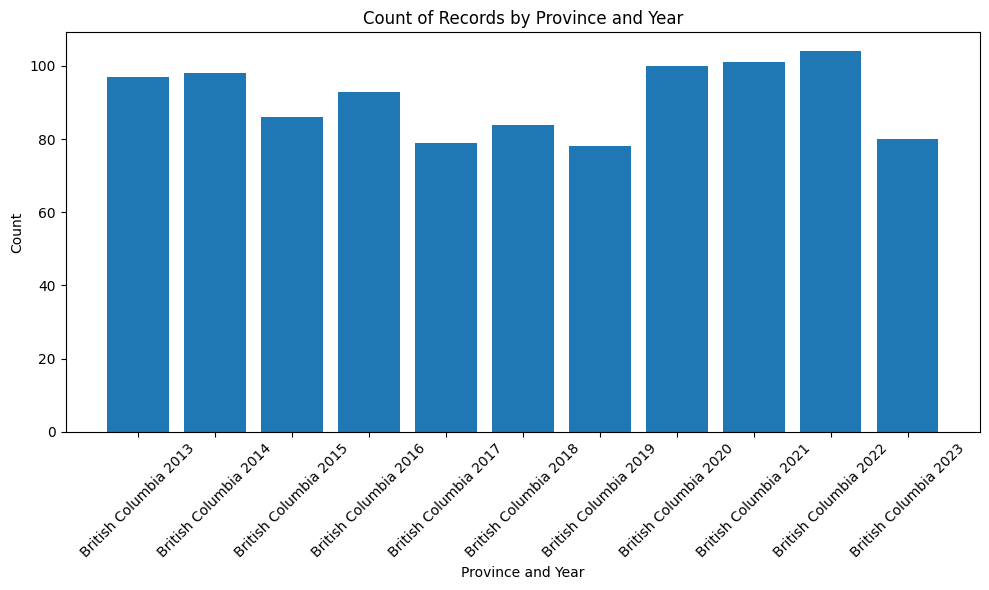

In [107]:
import matplotlib.pyplot as plt
graph = result.groupby(['ReportingProvince', 'Survey_Year']).size().reset_index(name='n')

plt.figure(figsize=(10, 6))
plt.bar(graph['ReportingProvince'] + ' ' + graph['Survey_Year'].astype(str), graph['n'])
plt.xlabel('Province and Year')
plt.ylabel('Count')
plt.title('Count of Records by Province and Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
